In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Plane regular waves - Airy (Linear) Theory
====================================================

Free-surface elevation equation:

$$
\eta(\vec{x},z,t)=0.5 H \cos (\vec{k}\cdot\vec{x}-\omega t +\phi) 
$$

Equation of velocity along the wave propagation direction:

$$
U_h(\vec{x},z,t)=0.5 H\omega \cos (\vec{k}\cdot\vec{x}-\omega t +\phi)\frac{\cosh(k(d+z))}{\sinh(kd)}
$$

Equation of velocity along the gravity direction:

$$
U_v(\vec{x},z,t)=0.5 H\omega \sin (\vec{k}\cdot\vec{x}-\omega t +\phi)\frac{\sinh(k(d+z))}{\sinh(kd)}
$$




Plane regular waves - Fenton Fourier Theory for nonlinear waves
====================================================

Free-surface elevation equation:

$$
\eta(\vec{x},z,t)=\frac{1}{|k|}\Sigma^{Nf}_i Y_i \cos i \cdot (\vec{ k}\cdot\vec{x}-\omega t +\phi) 
$$

Equation of velocity along the wave propagation direction:

$$
U_h(\vec{x},z,t)=\bar{U}+\sqrt{\frac{g}{k}} \Sigma^{Nf}_i iB_i \cos i \cdot (\vec{k}\cdot\vec{x}-\omega t +\phi)\frac{\cosh i\cdot(k(d+z))}{\cosh i \cdot (kd)}
$$

Equation of velocity along the gravity direction:

$$
U_v(\vec{x},z,t)=\sqrt{\frac{g}{k}} \Sigma^{Nf}_i iB_i \sin i \cdot (\vec{k}\cdot\vec{x}-\omega t +\phi)\frac{\sinh i\cdot(k(d+z))}{\cosh i \cdot (kd)}
$$




Setting up wave parameters for regular waves
=========================================

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import sys
from proteus import Comm
from proteus import Profiling
Profiling.procID=0
from proteus.Profiling import openLog

sys.path.append("C:/Users/present/Desktop/proteus/")
#The notebook will work with the following commit:
#https://github.com/erdc-cm/proteus/commit/9bb34b3563b5ddab6cb1dd9f75173da2710d2a41
from proteus import Profiling,SpatialTools
#import imp
#WT = imp.load_source('WaveTools', 'WaveTools.pyx')

from proteus import WaveTools as WT
from ipywidgets import HBox, Label, IntSlider, FloatSlider,FloatText, Dropdown, Tab, VBox, HBox,Box,Checkbox,IntText
from IPython.display import display
from proteus.WaveTools import dispersion
from numpy import pi


#============================WAVE PROPERTIES================================================================
waveType = Dropdown(value="Linear",options={"Linear":"Linear","Nonlinear":"Fenton"},description="Type")
waveHeight=FloatText(value=0.1,description="Height (m)")
period = FloatText(value=1.94,description="Period (s)")
depth =FloatText(value=1,description="Depth (m)")
x=FloatText(value=1,description="Dir: x")
y=FloatText(value=0,description="y")
z=FloatText(value=0,description="z")

wwl = dispersion(2*pi/period.value,depth.value)
wl=FloatText(value=2*pi/wwl,description="Wave length (m)")

#Setting dependencies of wavelength
def update_wl_p(args):
    ww = 2*pi/args['new']
    wl.value = 2*pi/dispersion(ww,depth.value)
def update_wl_d(args):
    wl.value = 2*pi/dispersion(2*pi/period.value,args['new'])
def update_wl_t(args):
    if(args["new"]=="Fenton"):
        wl.value = 0.
    else:
        wl.value = 2*pi/dispersion(2*pi/period.value,depth.value)

disclaimer = Label("")    
def update_dc_t(args):
    if(args["new"]=="Fenton"):
        disclaimer.value = "Fenton method is selected"
    else:
        disclaimer.value = ""

period.observe(update_wl_p,'value')
depth.observe(update_wl_d,'value')
waveType.observe(update_wl_t,'value')
waveType.observe(update_dc_t,'value')
direction = HBox([x,y,z])




#Setting wave properties tab
waveProperties = VBox([waveType,waveHeight,period,depth,wl,direction,disclaimer])

#=====================================ENVIRONMENTAL PROPERTIES========================================

mwl = FloatText(value=0,description="M.W.L (m)")

ux = FloatText(value=0,description="Current (m/s) x")
uy = FloatText(value=0,description="y")
uz = FloatText(value=0,description="z")
U = HBox([ux,uy,uz])

gx=FloatText(value=0,description="g(m/s2): x")
gy=FloatText(value=0,description="y")
gz=FloatText(value=-9.81,description="z")
gg = HBox([gx,gy,gz])

disclaimer2 = Label("Current velocities can only be defined only with nonlinear waves")    

def update_current(args):
    if(args["new"]=="Linear"):
        ux.value=0.
        uy.value=0.
        uz.value=0.

def update_dc_c(args):
    if(args["new"]=="Linear"):
        disclaimer2.value = "Current velocities can only be defined using nonlinear waves"
    else:
        disclaimer2.value = ""
waveType.observe(update_current,"value")
waveType.observe(update_dc_c,"value")
#Setting env properties tab
environmentalProperties = VBox([mwl,gg,U,disclaimer2])

#======================= RECONSTRUCTION OPTIONS================================
checkFast = Checkbox(value=False,disabled=False)
phase = FloatText(value=0,description="Wave phase")
Nf = IntText(value=1)
lnf=Label("No of Fourier components only to be used for Fenton (only set when Nonlinear waves are selected) ")
def update_Nf(args):
    if(waveType.value=="Linear"):
        Nf.value=1
    else:
        Nf.value=8
waveType.observe(update_Nf,'value')
opt=HBox([Label('Optimised functions?'),checkFast])
#Setting env properties tab
reconstructionProperties = VBox([phase,opt,lnf,Nf])

#================================TIME SERIES OPTIONS============================
checkTime = Checkbox(value=True,disabled=False)
minTime = FloatText(value=0,description="min")
maxTime = FloatText(value=5*period.value,description="max")
def updateRange(args):
    maxTime.value=5.*args['new']
period.observe(updateRange,"value")

optTime=HBox([Label('Plot time series?'),
            checkTime,
             Label('Range in (s)'),
             minTime,maxTime])
    
checkX = Checkbox(value=True,disabled=False)
minX = FloatText(value=0,description="min")
maxX = FloatText(value=5*wl.value,description="max")
def updateRangeX(args):
    maxX.value=5.*args['new']
wl.observe(updateRangeX,"value")
optX=HBox([Label('Plot contours?'),
            checkX,
             Label('Range in (m)'),
             minX,maxX])
timeOptions=VBox([optTime,optX,Label("Use z as the gravity axis for plotting contours")])

#=========================Setting up tabs======================================
tabTitles=["Wave Properties","Environmental properties","Reconstruction options","Wave series options"]
tabs = Tab(children=[waveProperties,environmentalProperties,reconstructionProperties,timeOptions])
for ii in range(len(tabTitles)):
    tabs.set_title(ii,tabTitles[ii])
display(tabs)







In [3]:
from ipywidgets import Button

In [16]:
from IPython.display import Javascript
Javascript('IPython.notebook.execute_cells_below()')

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = Button(description="Load WaveTools")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description='Load WaveTools', style=ButtonStyle())

In [17]:
openLog("WaveTools.log",1)

try:
    MW = WT.MonochromaticWaves(period=period.value,
                        waveHeight=waveHeight.value,
                        mwl=mwl.value,
                        depth=depth.value,
                        g=np.array([gx.value,gy.value,gz.value]),
                        waveDir=np.array([x.value,y.value,z.value]),
                        wavelength=wl.value,
                        waveType=waveType.value,
                        Nf = Nf.value,
                        meanVelocity=np.array([ux.value,uy.value,uz.value]),
                        phi0=phase.value,
                        )
    Profiling.closeLog()
    print("WaveTools loaded, click button above to reload")
except:
    print ("WaveTools did not load. Printing errors")
    Profiling.closeLog()
    ff=open("WaveTools.log","r")
    loglines = ff.readlines()
    line1 =""
    for line in loglines:
        if line != line1:
            print (line) 
        line1=line
    ff.close()
import os
os.remove("WaveTools.log")

WaveTools loaded, click button above to reload


Calculating and plotting waves
=============================================================



In [18]:
if(checkTime.value):
    xx = FloatText(value=0,description="x:")
    yy = FloatText(value=0,description="y:")
    zz = FloatText(value=mwl.value-depth.value/2.,description="z:")
    display(HBox([xx,yy,zz]))
    psize = 20 


In [19]:
from IPython.display import Javascript
from ipywidgets import Button
Javascript('IPython.notebook.execute_cells_below()')

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = Button(description="Update plots")
button.on_click(run_all)
display(button)

Button(description='Update plots', style=ButtonStyle())

-2.0


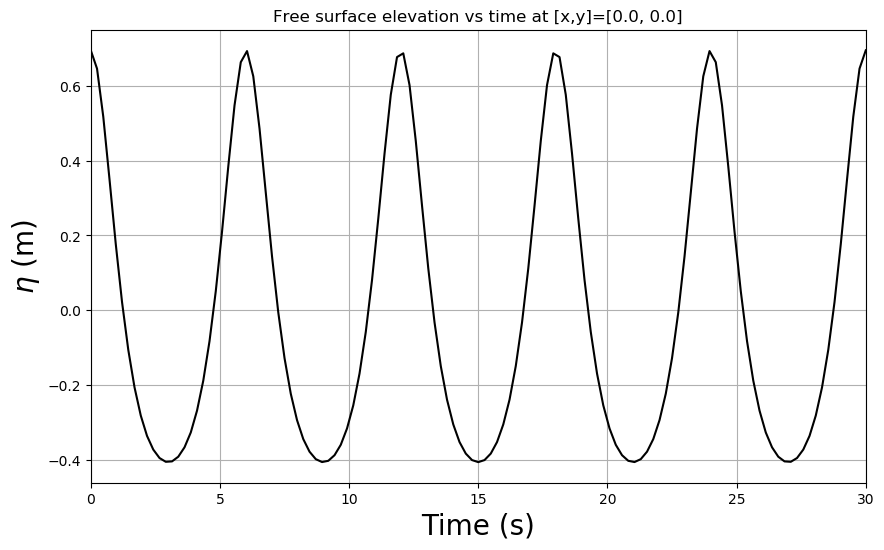

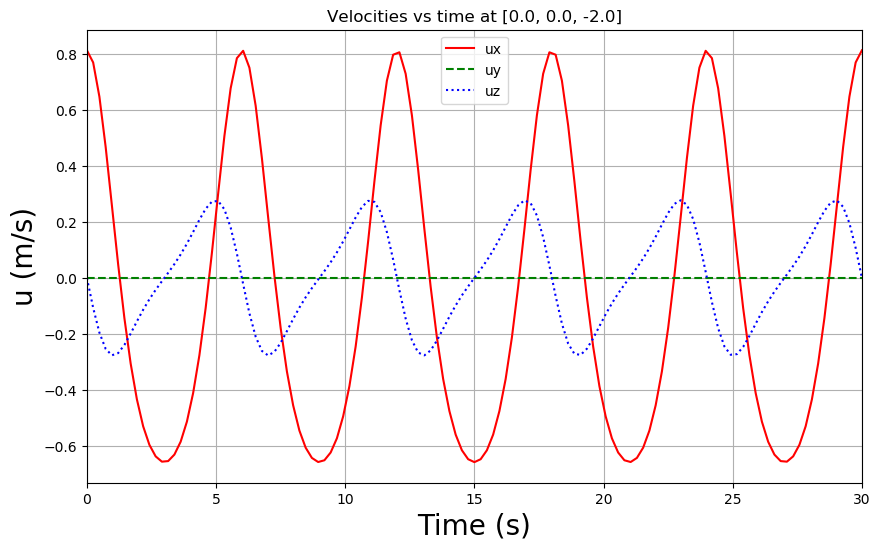

In [20]:
#Calculating time series
print (zz.value)
if(checkTime.value):
    xo = [xx.value, yy.value, zz.value]
    dt = period.value/25.
    Ndt = maxTime.value-minTime.value
    Ndt = int(Ndt/dt)
    tnlist = np.linspace(minTime.value,maxTime.value,Ndt)
    eta_t=np.zeros(Ndt).copy()
    uux=np.zeros(Ndt).copy()
    uuy=np.zeros(Ndt).copy()
    uuz=np.zeros(Ndt).copy()
    for i in range(len(tnlist)):
        t = tnlist[i]
        eta_t[i] = MW.eta(xo, t)
        uux[i],uuy[i],uuz[i] = MW.u(xo, t)
    plt.figure(2,figsize=(10,6), dpi=100)
    plt.title("Free surface elevation vs time at [x,y]="+str(xo[:2]))
    plt.xlim(minTime.value, maxTime.value)
    plt.plot(tnlist, eta_t,"k-")
    plt.xlabel("Time (s)", size=psize)
    plt.ylabel("$\eta$ (m)", size=psize)
    plt.grid()
    plt.show()
    
    plt.figure(3,figsize=(10,6), dpi=100)
    plt.title("Velocities vs time at "+str(xo))
    plt.xlim(minTime.value, maxTime.value)
    plt.plot(tnlist, uux,"r-",label="ux")
    plt.plot(tnlist, uuy,"g--",label="uy")
    plt.plot(tnlist, uuz,"b:",label="uz")
    plt.xlabel("Time (s)", size=psize)
    plt.ylabel("u (m/s)", size=psize)
    plt.legend()
    plt.grid()
    plt.show()

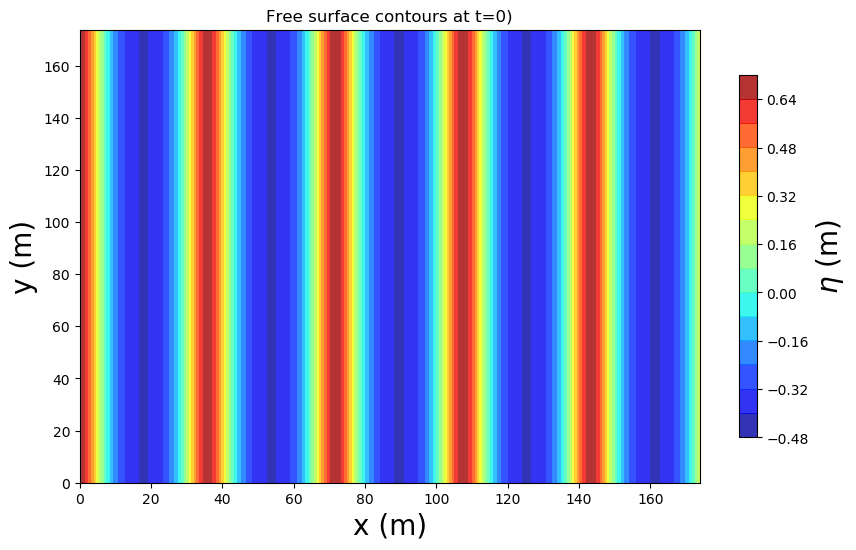

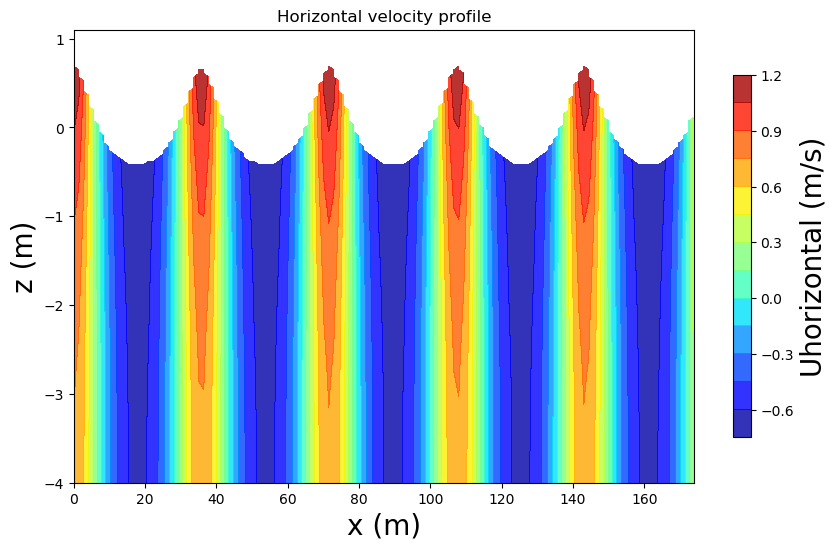

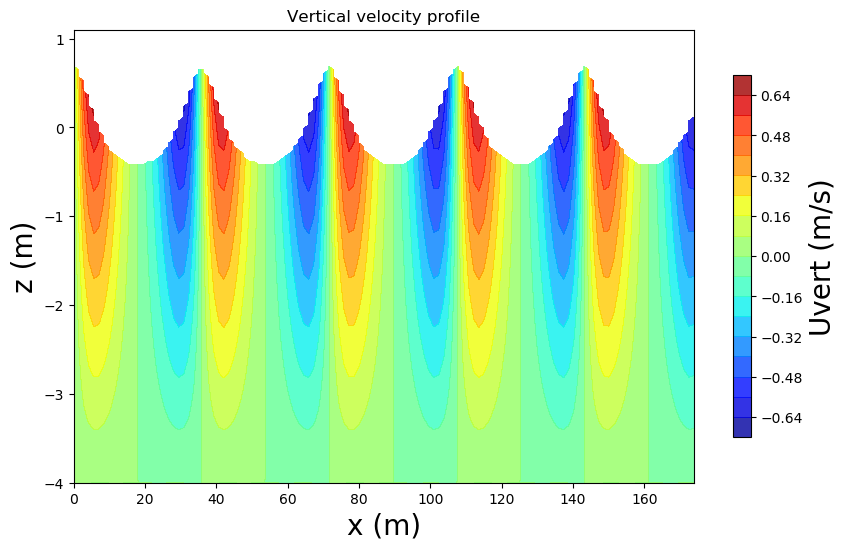

In [21]:
psize=20
if checkX.value:
    dx=wl.value/25.
    Ndx = maxX.value-minX.value
    n = int(Ndx/dx)
    eta_xy = np.zeros((n, n),)
    xi =np.linspace(minX.value,maxX.value,n)
    ddepth = min(wl.value,depth.value)
    dz = ddepth/50.
    nz = int((ddepth)/dz)
    zi =np.linspace(mwl.value-ddepth,mwl.value+waveHeight.value,n)

    for i in range(n):
        for j in range(n):
            xo = [xi[i], xi[j], 0]
            eta_xy[i,j] = MW.eta(xo, 0.)
    #Plotting the contour
    plt.figure(1,figsize=(10, 6), dpi=100)
    plt.title("Free surface contours at t=0)")

    X,Y = np.meshgrid(xi,xi)
    CS = plt.contourf(Y,X,eta_xy, 16, alpha=0.8, cmap='jet')
    plt.xlabel("x (m)", size=psize)
    plt.ylabel("y (m)", size=psize)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    CB.set_label("$\eta$ (m)", size = psize)
    plt.xlim(min(xi),max(xi))
    plt.ylim(min(xi),max(xi))         
    plt.show()
    
    norm = WT.setDirVector(np.array([x.value,y.value,z.value]))
    normVert = WT.setVertDir(np.array([gx.value,gy.value,gz.value]))
    ur  = np.zeros((len(xi),len(zi)),)
    uv  = np.zeros((len(xi),len(zi)),)
    for i in range(len(xi)):
        for ii in range(len(zi)):
            xoo = xi[i]*norm + [0,0,zi[ii]]
            U = MW.u(xoo, 0.)
            ur[i,ii] = sum(U[:]*norm[:])
            uv[i,ii] = sum(U[:]*normVert[:])
            if zi[ii]>  MW.eta(xoo, 0.):
                ur[i,ii] = np.nan
                uv[i,ii] = np.nan

    #Plotting velocity contours
    plt.figure(5,figsize=(10, 6), dpi=100)
    plt.title("Horizontal velocity profile")
    X,Y = np.meshgrid(zi,xi)
    CS = plt.contourf(Y,X,ur, 16, alpha=0.8, cmap='jet')
    plt.xlabel("x (m)", size=psize)
    plt.ylabel("z (m)", size=psize)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    CB.set_label("Uhorizontal (m/s)", size = psize)
    plt.xlim(min(xi),max(xi))
    plt.ylim(min(zi),max(zi))         
    plt.show()

    plt.figure(6,figsize=(10, 6), dpi=100)
    plt.title("Vertical velocity profile")
    X,Y = np.meshgrid(zi,xi)
    CS = plt.contourf(Y,X,uv, 16, alpha=0.8, cmap='jet')
    plt.xlabel("x (m)", size=psize)
    plt.ylabel("z (m)", size=psize)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    CB.set_label("Uvert (m/s)", size = psize)
    plt.xlim(min(xi),max(xi))
    plt.ylim(min(zi),max(zi))         
    plt.show()